![Police brutality](img/top_banner.png)

# Fatal Police Shootings in the United States
Fatal police shootings are a major issue in the United States, and there is growing public concern about systemic issues within the law enforcement community that may be contributing to these incidents. The US Department of Justice has initiated a critical investigation into fatal police shootings, and this analysis aims to identify and address the key challenges in police activity by leveraging data-driven insights.
## Scope of analysis
In this analysis, we will examine multiple facets of the issue, including: 
- records of fatal police shootings;
- incidents involving officers killed;
- race distribution in the US.

Our primary dataset focuses on fatal police shootings that have been recorded between the years 2015 and 2017.

## _Load data_

First we need to import required libraries for our analysis:

In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Setting global plotting style to use custom style sheet
plt.style.use('custom_style.mplstyle')

Load the main dataset provided in the capstone project and check the sample. 
This dataset has the information of fatal shootings from 2015-01-02 to 
2017-02-28. When comparing other datasets we will have this in mind.

In [297]:
df_fatal_shootings = pd.read_csv('data/fatal_shootings_15-17.csv', index_col=0)
df_fatal_shootings.head()

,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
id,,,,,,,,,,,,,
3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


## _Data cleanup_

Let's look at what data we have in more detail. For this we can write simple
 function which gives us this overview:

In [298]:
def print_overview(df):
      print('Data types of columns:')
      print(df.dtypes)
      print('\nSum of null values:')
      nan_counts = df.isnull().sum()
    
      for column, count in nan_counts.items():
            if count > 0:
                  print(f"Column '{column}' has {count} NaN values.")
      

In [299]:
print_overview(df_fatal_shootings)

Data types of columns:
name                        object
date                        object
manner_of_death             object
armed                       object
age                        float64
gender                      object
race                        object
city                        object
state                       object
signs_of_mental_illness       bool
threat_level                object
flee                        object
body_camera                   bool
dtype: object

Sum of null values:
Column 'name' has 19 NaN values.
Column 'armed' has 6 NaN values.
Column 'age' has 43 NaN values.
Column 'gender' has 1 NaN values.
Column 'race' has 103 NaN values.
Column 'flee' has 36 NaN values.


From data type overview we see that date column is not in datetime format so 
we need to change this:

In [300]:
df_fatal_shootings['date'] = pd.to_datetime(df_fatal_shootings['date'])

Now when it is changed let's see what time range are we working with:

In [301]:
min_date = df_fatal_shootings['date'].min()
max_date = df_fatal_shootings['date'].max()

print(f"Time Range: {min_date} to {max_date}")

Time Range: 2015-01-02 00:00:00 to 2017-02-28 00:00:00


Now let's deal with missing values:

Missing values in name column will be changed to _'John Doe'_:

In [302]:
df_fatal_shootings['name'].fillna(value='John Doe', inplace=True)

Age column has number values so we will fill those with mean value of that column so it doesn’t create outliers and it won’t affect the results very much as there are only 43 NaN values.

In [303]:
min_age = int(df_fatal_shootings['age'].min())
max_age = int(df_fatal_shootings['age'].max())
mean_age = int(df_fatal_shootings['age'].mean())

print(f"Person age varies between {min_age} and {max_age} with a mean value "
      f"of {mean_age}")

Person age varies between 6 and 86 with a mean value of 36


In [304]:
df_fatal_shootings['age'].fillna(value=mean_age, inplace=True)

Columns 'flee' and 'race' have values for 'Other' so we can use those:

In [305]:
df_fatal_shootings['flee'].fillna(value='Other', inplace=True)
df_fatal_shootings['race'].fillna(value='O', inplace=True)

In columns 'armed' and 'gender' we will fill 'unknown'

In [306]:
df_fatal_shootings[['armed', 'gender']] = df_fatal_shootings[['armed', 'gender']].fillna(value='unknown')

Now we should have no null values and date column should be in correct format:

In [307]:
print_overview(df_fatal_shootings)

Data types of columns:
name                               object
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                               float64
gender                             object
race                               object
city                               object
state                              object
signs_of_mental_illness              bool
threat_level                       object
flee                               object
body_camera                          bool
dtype: object

Sum of null values:


Also for easier reading we can add full state names column:

In [308]:
df_state_names = pd.read_csv('data/state_names.csv')
df_fatal_shootings = pd.merge(df_fatal_shootings, 
                              df_state_names[['state_name', 'state']], 
                              on='state', 
                              how='left')

## _Data analysis_

### _Age_

We will start this data analysis by looking at the age distribution in this 
dataset. To have better visual representation we will create age groups and 
see which ones have the most values.

In [309]:
# Define age group intervals
age_bins = [0, 18, 30, 45, 60, float('inf')]

# Define labels for the age groups
age_labels = ['0-18', '19-30', '31-45', '46-60', '61+']

# Use pd.cut to categorize ages into age groups
df_fatal_shootings['age_group'] = pd.cut(df_fatal_shootings['age'], 
                                         bins=age_bins, labels=age_labels)

# Count the number of occurrences in each age group
age_group_counts = df_fatal_shootings['age_group'].value_counts()


After creating these age group bins we can visualise this data: 

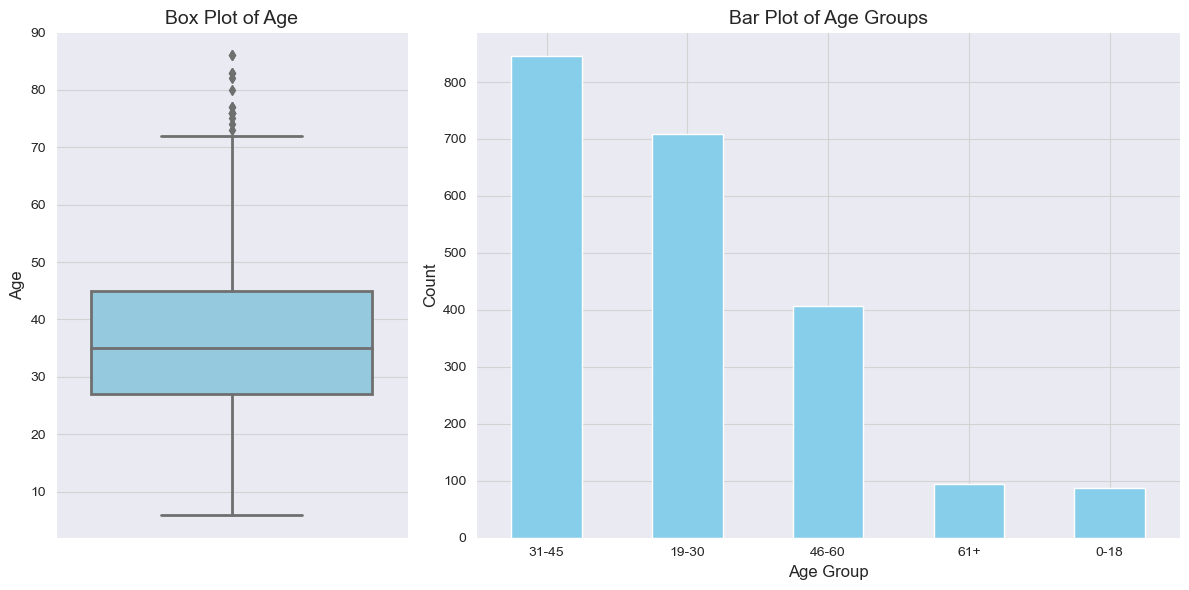

In [310]:
# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': 
                                                                 [1, 2]})

# Plot 1: Box plot of age
ax1 = sns.boxplot(data=df_fatal_shootings, y='age', ax=axes[0])
ax1.set_ylabel('Age')
ax1.set_title('Box Plot of Age')

# Plot 2: Age groups
ax2 = age_group_counts.plot(kind='bar', ax=axes[1])
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Count')
ax2.set_title('Bar Plot of Age Groups')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

The data shows that most people shot by the police are between 31 and 45 
years old. One possible explanation is that police officers are more likely to use deadly force against people in this age group. This may be because people in this age group look and act more similar to police officers themselves, which may make them appear more threatening.

We can also look how and if different age groups are fleeing from the police.
 We will also look at different genders in this case.

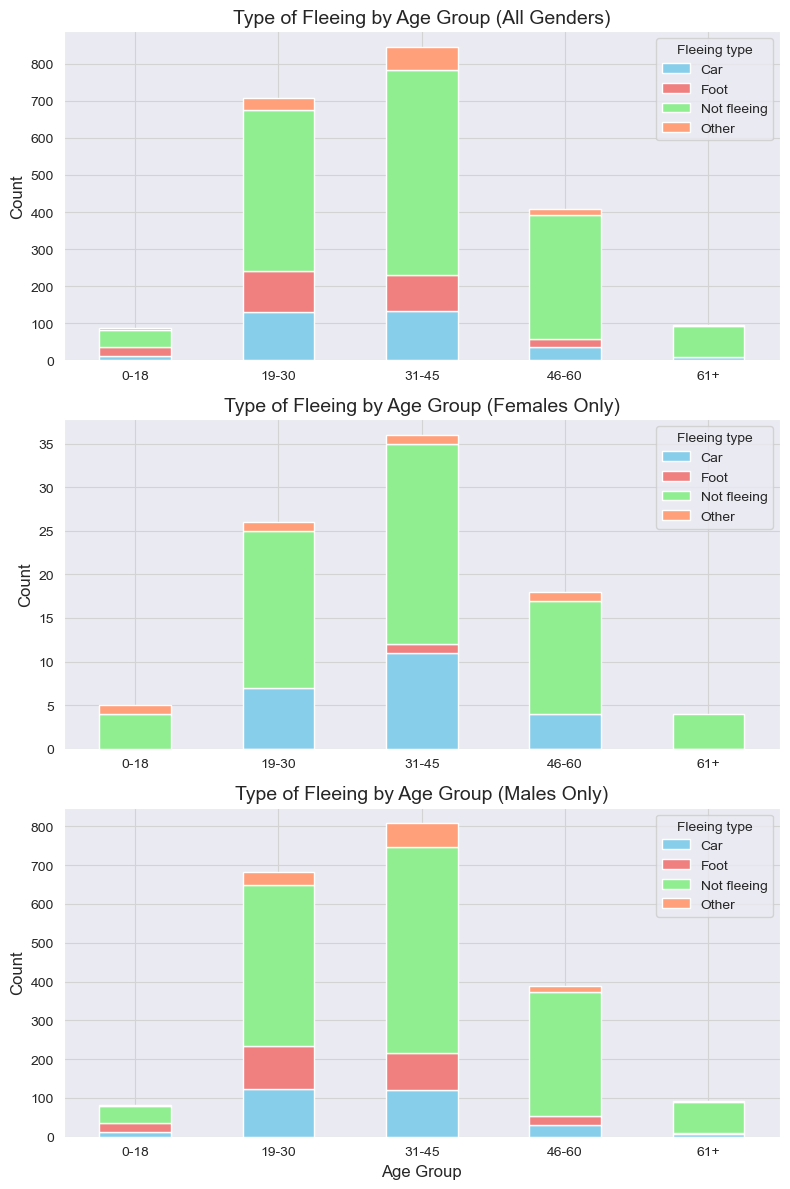

In [311]:
cross_tab_flee = pd.crosstab(df_fatal_shootings['age_group'], 
                             df_fatal_shootings['flee'])

# Create a 3x1 grid of subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot 1: Type of fleeing by age group (all genders)
cross_tab_all = pd.crosstab(df_fatal_shootings['age_group'], df_fatal_shootings['flee'])
ax1 = cross_tab_all.plot(kind='bar', stacked=True, ax=axes[0])
ax1.set_xlabel('')
ax1.set_ylabel('Count')
ax1.set_title('Type of Fleeing by Age Group (All Genders)')
ax1.legend(title='Fleeing type')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Plot 2: Type of fleeing by age group (Females only)
female_df = df_fatal_shootings[df_fatal_shootings['gender'] == 'F']
cross_tab_female = pd.crosstab(female_df['age_group'], female_df['flee'])
ax2 = cross_tab_female.plot(kind='bar', stacked=True, ax=axes[1])
ax2.set_xlabel('')
ax2.set_ylabel('Count')
ax2.set_title('Type of Fleeing by Age Group (Females Only)')
ax2.legend(title='Fleeing type')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Plot 3: Type of fleeing by age group (Males only)
male_df = df_fatal_shootings[df_fatal_shootings['gender'] == 'M']
cross_tab_male = pd.crosstab(male_df['age_group'], male_df['flee'])
ax3 = cross_tab_male.plot(kind='bar', stacked=True, ax=axes[2])
ax3.set_ylabel('Count')
ax3.set_title('Type of Fleeing by Age Group (Males Only)')
ax3.legend(title='Fleeing type')
ax3.set_xticklabels(ax1.get_xticklabels(), rotation=0)


# Adjust spacing between subplots
plt.tight_layout()

plt.xlabel('Age Group')
# Show the combined plot
plt.show()

Police encounters may be more likely to make women feel less safe or more threatened, which could lead them to flee. People aged 19-45 are also more likely to engage in risky behaviors, such as driving under the influence or fleeing the scene of a crime, which could make them more likely to flee police encounters. Additionally, people aged 19-45 are more likely to own or have access to cars, which can make it easier for them to flee.

### _Race_

Next let's look at the race and how it is distributed in these age groups.

In [312]:
# Create a contingency table (cross-tabulation) of 'race' and 'age_group'
cross_tab_race = pd.crosstab(df_fatal_shootings['age_group'], 
                         df_fatal_shootings['race'])

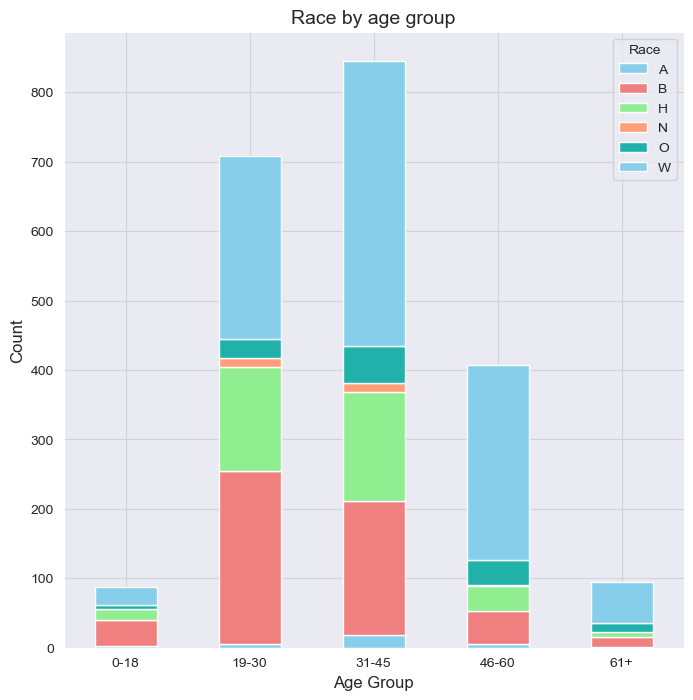

In [313]:
# Create a stacked bar chart
ax = cross_tab_race.plot(kind='bar', stacked=True, figsize=(8, 8))

# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Race by age group')
plt.xticks(rotation=0)

# Customize the legend
plt.legend(title='Race')

# Show the plot
plt.show()

From this data we can see that most shot by police people are of White, Black
 and Hispanic races. This might be because these are the most populous races 
 in US. We can see this by looking at oficial census data [Race Distribution in US](https://www.census.gov/quickfacts/fact/table/US/RHI725222)

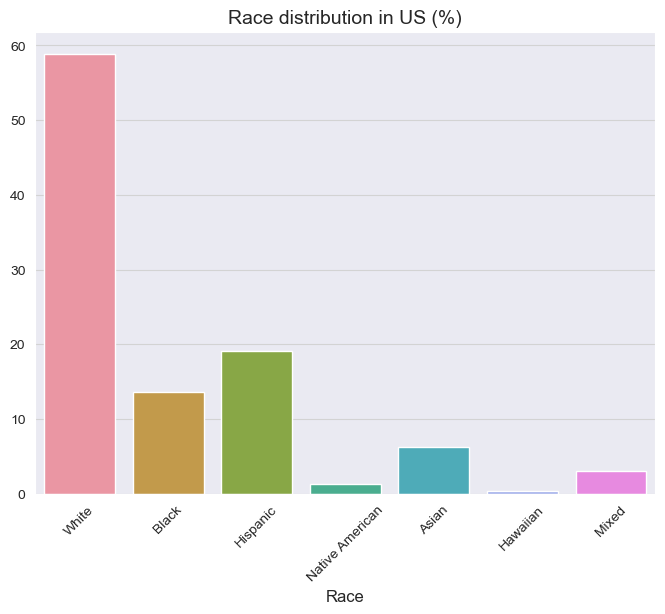

In [314]:
df_race_distribution = pd.read_csv('data/race_distribution_us.csv')

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_race_distribution)

# Add labels and title
plt.xlabel('Race')
plt.title('Race distribution in US (%)')
plt.xticks(rotation=45)

# Show the plot
plt.show()

The data shows that the highest rate of people shot by police is among the most populous races. However, what is striking is that black people make up only one-quarter of the white population, yet are shot by police only two times less often. Additionally, there are more Hispanic people than black people, yet they are shot by police even less often.

In [315]:
df_race_count = df_fatal_shootings['race'].value_counts().reset_index()

total_count = df_race_count['count'].sum()

df_race_count['percentage'] = df_race_count['count'] / total_count
df_race_count

,race,count,percentage
0,W,1041,0.485994
1,B,542,0.253035
2,H,367,0.171335
3,O,131,0.061158
4,A,33,0.015406
5,N,28,0.013072


In [316]:
df_race_distribution

,White,Black,Hispanic,Native American,Asian,Hawaiian,Mixed
0,58.9,13.6,19.1,1.3,6.3,0.3,3


In summary, the data highlights disparities in police shootings among racial groups, with black individuals experiencing a disproportionately higher rate of police shootings relative to their population size. 

### _Geography_

Now let's look at what states have the highest number of incidents:

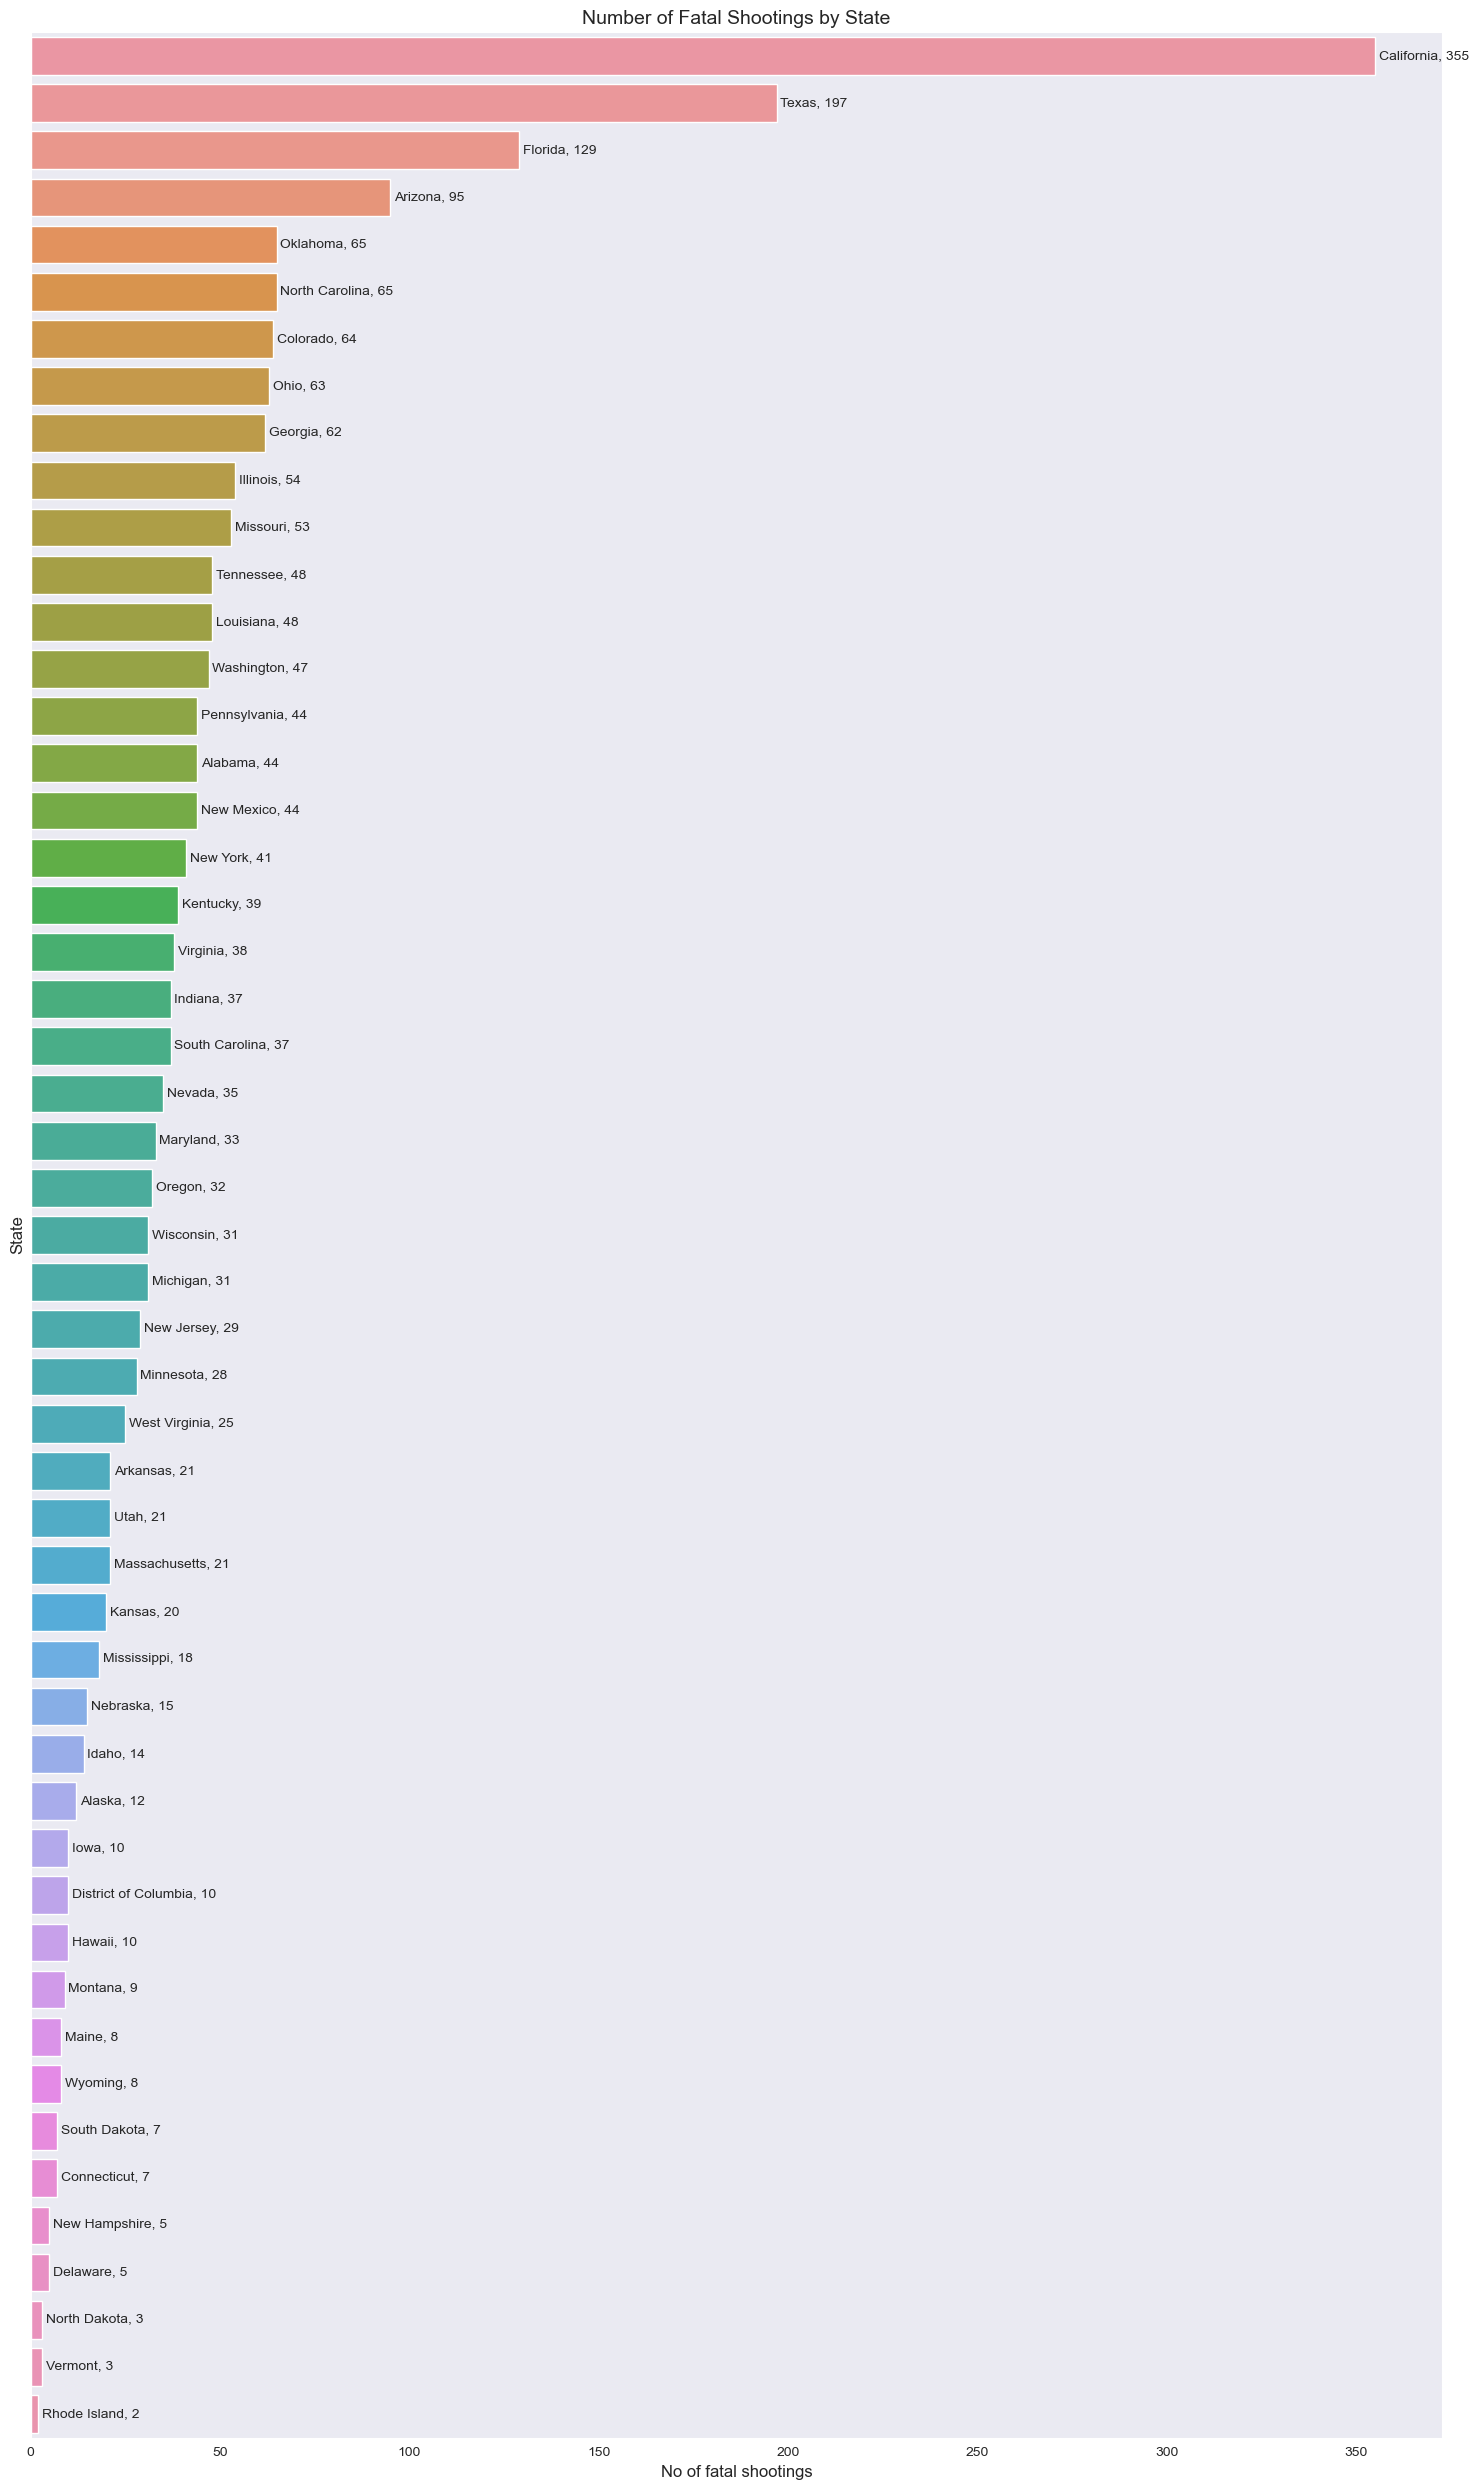

In [317]:
# Count the number of states
state_counts = df_fatal_shootings['state_name'].value_counts()

# Get the list of state names in order of highest number of states
state_names = state_counts.index.tolist()
state_names = sorted(state_names, key=lambda x: state_counts[x], reverse=True)

plt.figure(figsize=(15, 25))  # Adjust the figure size to accommodate the longer y-axis labels

# Create a bar chart
sns.countplot(data=df_fatal_shootings, y='state_name', order=state_names)  # Use 'y' for the y-axis

# Hide the y-axis ticks
plt.yticks([])

# Add text beside the columns
for i in range(len(state_names)):
  # Get the width of the column
  width = plt.gca().patches[i].get_width()

  # Add the text beside the column, align right
  plt.text(x=width + 1, y=i, 
           s=f"{state_names[i]}, {state_counts[state_names[i]]}", rotation=0,
           ha='left', va='center')

# Add labels and title
plt.xlabel('No of fatal shootings')
plt.ylabel('State')
plt.title('Number of Fatal Shootings by State')

# Tighten the layout
plt.tight_layout()

# Show the plot
plt.show()

We can also visualise this on a map using geopandas. For that we will need to
 load map shapefile and calculate shooting count for each state.

In [318]:
shapefile = 'geodata/States_shapefile.shp'
gdf = gpd.read_file(shapefile)

state_counts = df_fatal_shootings['state'].value_counts()

We then merge these dataframes and create a map plot from this:

In [319]:
merged_gdf = gdf.merge(state_counts, left_on='State_Code', right_on='state', 
                       how='left')

As we are more interested in mainland US we can remove Alaska, Hawaii and 
American Samoa from this map to make it more compact.

In [320]:
merged_gdf = merged_gdf[merged_gdf['State_Code'].isin(['AK', 'AS', 'HI']) == False]

Also we can compare the data from another dataset which has events of 
police officers killed and see if there are similarities. For example if 
states that have more police officers killed also have more fatal shootings 
by police.

In [321]:
df_police_deaths = pd.read_csv('data/police_deaths_538.csv')

Let's check the data using earlier created function:

In [322]:
print_overview(df_police_deaths)

Data types of columns:
person         object
dept           object
eow            object
cause          object
cause_short    object
date           object
year            int64
canine           bool
dept_name      object
state          object
dtype: object

Sum of null values:


In [323]:
df_police_deaths['date'] = pd.to_datetime(df_police_deaths['date'])

In [324]:
min_date = df_police_deaths['date'].min()
max_date = df_police_deaths['date'].max()

print(f"Time Range: {min_date} to {max_date}")

Time Range: 1791-01-03 00:00:00 to 2016-07-03 00:00:00


As we can see this dataset is very large and we are only interested in time 
range that is comparable with our main dataset. So we need to filter it out.

In [325]:
df_police_deaths_filtered = df_police_deaths[df_police_deaths['date'] >= '2015-01-02']

In [326]:
df_police_deaths_by_state = df_police_deaths_filtered['state'].value_counts().reset_index()

# Remove leading/trailing whitespace
df_police_deaths_by_state['state'] = df_police_deaths_by_state['state'].str.strip()

Let's create dataset with count and geo information for plotting:

In [327]:
merged_gdf_pd = gdf.merge(df_police_deaths_by_state, 
                          left_on='State_Code', right_on='state', how='left')

In [328]:
merged_gdf_pd['count'] = merged_gdf_pd['count'].fillna(0)

Let's also remove states that are not relevant in this case:

In [329]:
merged_gdf_pd = merged_gdf_pd[merged_gdf_pd['State_Code'].isin(['AK', 'AS', 'HI']) == False]

Let's draw maps from this data:

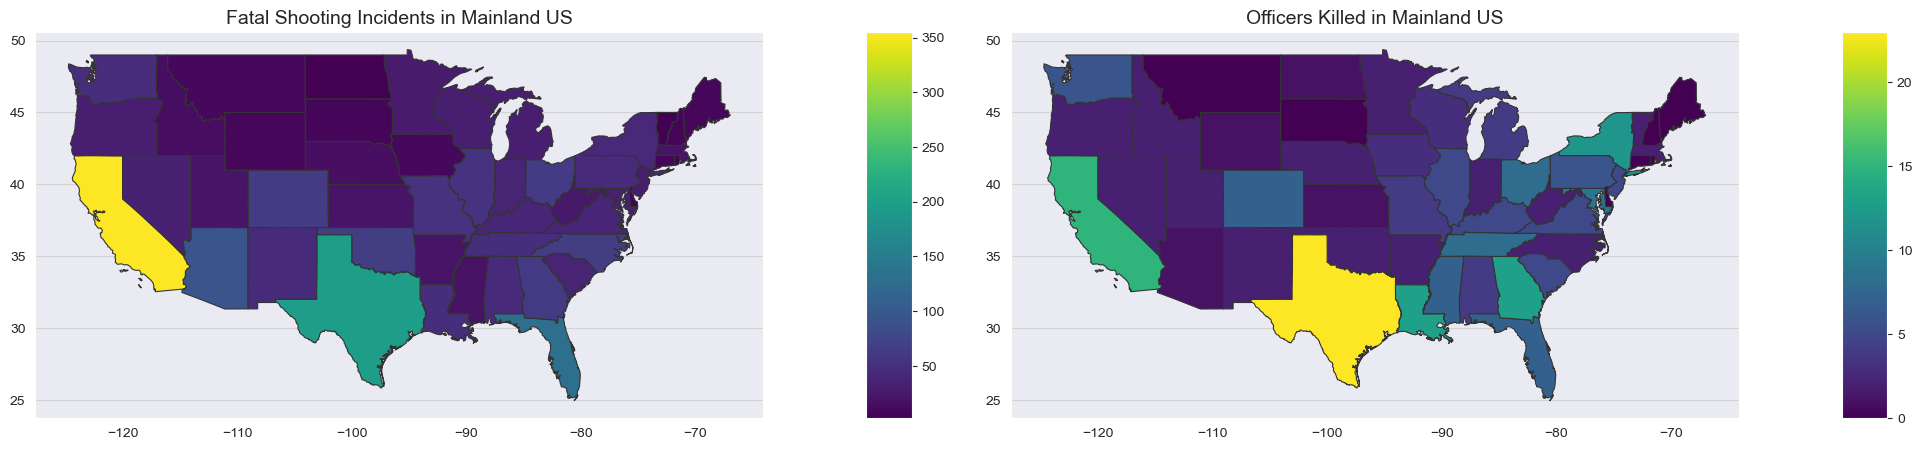

In [332]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 15))

# Plot the first map on the left subplot
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
merged_gdf.plot(column='count', cmap='viridis', edgecolor='0.2', linewidth=0.8, 
                ax=axes[0], legend=True, cax=cax)
axes[0].set_title('Fatal Shooting Incidents in Mainland US')

# Plot the second map on the right subplot
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
merged_gdf_pd.plot(column='count', cmap='viridis', edgecolor='0.2', linewidth=0.8, 
                ax=axes[1], legend=True, cax=cax)
axes[1].set_title('Officers Killed in Mainland US')

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plots
plt.show()

# Conclusion

In this project, our data analysis has shed light on the significant role that race plays in fatal shooting incidents. Notably, despite comprising only a quarter of the population, Black individuals are shot at a rate that is twice as high as other racial groups. However, it's crucial to emphasize that race is just one of several contributing factors.

When we delve into age groups, it becomes evident that young adults are the most frequently shot demographic. This can be attributed to their higher levels of physical activity, which may lead them to appear more threatening to law enforcement officers. Moreover, they are often involved in criminal activities and may resist or attempt to flee, frequently having access to vehicles.

Examining the geographical distribution of these incidents, we observe that states with a higher number of police officers killed also witness more fatal shootings. This correlation suggests that officers in these regions may be more prone to using excessive force due to heightened caution following incidents involving their colleagues.

In summary, it is challenging to pinpoint a single reason for these incidents, if such a reason exists at all. Rather, they result from a complex interplay of various social, economic, and geographic factors. Deeper and more comprehensive studies are imperative to gain a more nuanced understanding of this issue.